<a href="https://colab.research.google.com/github/normalnon/Advanced-Data-Filtering/blob/main/Workshop3_Deduplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exact deduplication

In [ ]:
# วิธีที่ 1: Python set
data = ["hello", "world", "hello", "python"]
unique = list(set(data))
print(unique)  # ['hello', 'world', 'python']

# วิธีที่ 2: Hash-based
import hashlib

def hash_text(text):
    return hashlib.md5(text.encode()).hexdigest()

data = ["hello world", "hello world", "hi there"]
seen = set()
unique = []

for text in data:
    h = hash_text(text)
    if h not in seen:
        seen.add(h)
        unique.append(text)

print(unique)

['python', 'world', 'hello']
['hello world', 'hi there']


# Fuzzy deduplication

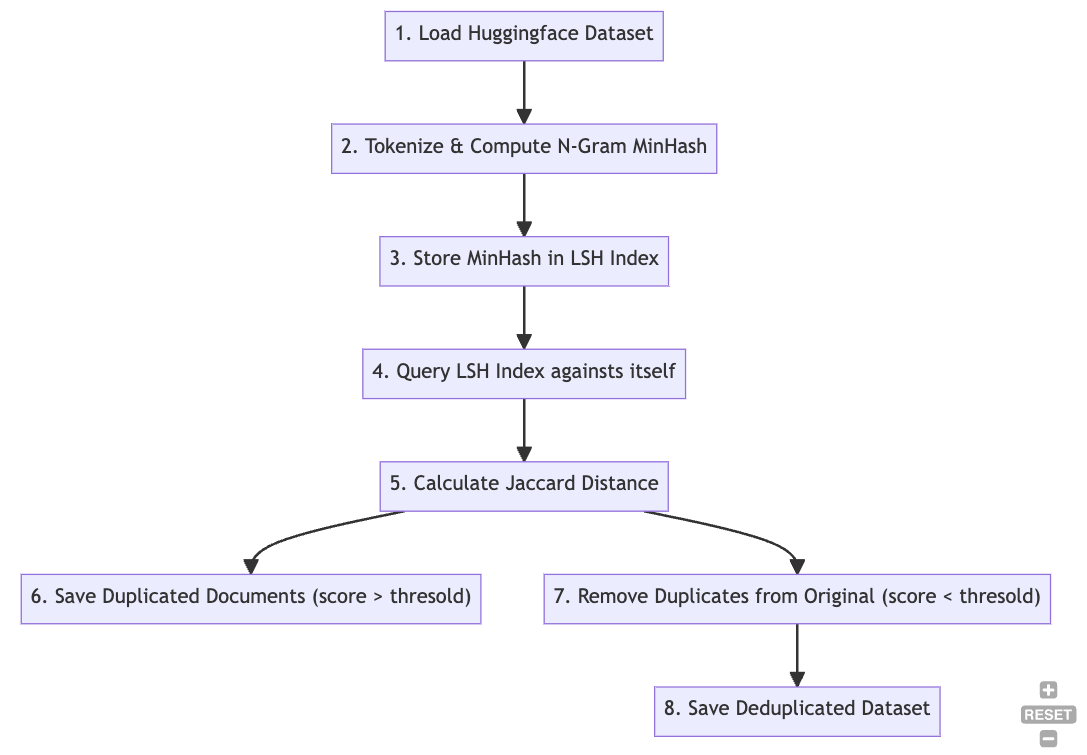

ref: https://github.com/OpenThaiGPT/data-processing/blob/main/scripts/deduplication/deduplication_diagram.png

## Import libraries

In [ ]:
# Import libraries
import hashlib
from collections import defaultdict
from typing import List, Set, Tuple, Dict

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 🧮 MinHash + LSH คืออะไร?

---

### 📌 MinHash (Minimum Hashing):
1. แปลงเอกสารเป็น **"signature"** ขนาดเล็ก
2. Signature คล้ายกัน = เอกสารคล้ายกัน
3. ใช้เปรียบเทียบแทนเอกสารตัวจริง (เร็วกว่า)

**ตัวอย่าง:**
```
Document: "The quick brown fox"
Signature: [12345, 67890, 24680, ...]  (100 numbers)
```

---

### 📌 LSH (Locality-Sensitive Hashing):
1. จัดกลุ่มเอกสารที่คล้ายกันเข้า **"bucket"** เดียวกัน
2. เปรียบเทียบแค่เอกสารใน bucket เดียวกัน
3. ข้าม bucket ที่ต่างกัน (ประหยัดเวลา)

**ตัวอย่าง:**
```
Bucket A: [Doc1, Doc2, Doc5]     ← เปรียบเทียบเฉพาะใน bucket นี้
Bucket B: [Doc3, Doc7]           ← เปรียบเทียบเฉพาะใน bucket นี้
Bucket C: [Doc4, Doc6, Doc8]     ← เปรียบเทียบเฉพาะใน bucket นี้
```

---

### 🎯 ผลลัพธ์:
✅ เร็วกว่า brute force มาก  
✅ แม่นยำใกล้เคียงกัน  
✅ Scale ได้ดี (millions of documents)

### Step 1 - Shingles

#### 📝 STEP 1: Shingles (k-grams)

---

### Shingles คืออะไร?
- **ชุดของ substring ความยาว k**
- ใช้แทนเอกสารเพื่อเปรียบเทียบ

### ตัวอย่าง:
```
Text: "hello"
k=2 → Shingles: {"he", "el", "ll", "lo"}

Text: "hello world"  
k=3 → Shingles: {"hel", "ell", "llo", "low", "owo", "wor", "orl", "rld"}
```

### ทำไมต้องใช้ Shingles?
- จับ **local patterns** ได้ดี
- Robust ต่อ small changes
- ใช้คำนวณ similarity ได้

In [ ]:
def get_shingles(text: str, k: int = 3) -> Set[str]:
    """สร้าง k-gram shingles จากข้อความ"""
    # Normalize
    text = text.lower().replace(" ", "")

    # สร้าง k-grams
    shingles = set([text[i:i+k] for i in range(len(text) - k + 1)])

    return shingles


# ทดสอบ Shingles
print("="*70)
print("🔹 Demo: Shingles Generation")
print("="*70)

test_texts = [
    "hello",
    "hello world",
    "The quick brown fox",
]

for text in test_texts:
    shingles = get_shingles(text, k=3)
    print(f"\nText: '{text}'")
    print(f"Normalized: '{text.lower().replace(' ', '')}'")
    print(f"Shingles (k=3): {shingles}")
    print(f"Count: {len(shingles)}")

🔹 Demo: Shingles Generation

Text: 'hello'
Normalized: 'hello'
Shingles (k=3): {'llo', 'ell', 'hel'}
Count: 3

Text: 'hello world'
Normalized: 'helloworld'
Shingles (k=3): {'ell', 'wor', 'orl', 'llo', 'rld', 'low', 'owo', 'hel'}
Count: 8

Text: 'The quick brown fox'
Normalized: 'thequickbrownfox'
Shingles (k=3): {'heq', 'ckb', 'kbr', 'equ', 'ick', 'row', 'wnf', 'qui', 'the', 'uic', 'own', 'nfo', 'fox', 'bro'}
Count: 14


### Jaccard Similarity

#### 📊 Jaccard Similarity

---

### สูตร:
```
Jaccard(A, B) = |A ∩ B| / |A ∪ B|
```

- **Intersection (∩):** สมาชิกที่อยู่ทั้ง A และ B
- **Union (∪):** สมาชิกทั้งหมดของ A และ B

### ค่าที่ได้:
- **0.0** = ไม่เหมือนกันเลย
- **1.0** = เหมือนกัน 100%

### ตัวอย่าง:
```
A = {1, 2, 3, 4}
B = {3, 4, 5, 6}

A ∩ B = {3, 4}         → 2 elements
A ∪ B = {1,2,3,4,5,6}  → 6 elements

Jaccard = 2/6 = 0.33
```

In [ ]:
def jaccard_similarity(set1: Set[str], set2: Set[str]) -> float:
    """คำนวณ Jaccard Similarity"""
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0.0


# ทดสอบ Jaccard
print("="*70)
print("🔹 Demo: Jaccard Similarity")
print("="*70)

# ตัวอย่าง 1: ข้อความคล้ายกัน
text1 = "The quick brown fox"
text2 = "The quick brown dog"

shingles1 = get_shingles(text1, k=3)
shingles2 = get_shingles(text2, k=3)

similarity = jaccard_similarity(shingles1, shingles2)

print(f"\nText 1: '{text1}'")
print(f"Shingles 1: {len(shingles1)} shingles")

print(f"\nText 2: '{text2}'")
print(f"Shingles 2: {len(shingles2)} shingles")

print(f"\nIntersection: {len(shingles1 & shingles2)} shingles")
print(f"Union: {len(shingles1 | shingles2)} shingles")
print(f"\n✅ Jaccard Similarity: {similarity:.3f}")

print("\n" + "-"*70)

# ตัวอย่าง 2: ข้อความต่างกัน
text3 = "The quick brown fox"
text4 = "Hello world"

shingles3 = get_shingles(text3, k=3)
shingles4 = get_shingles(text4, k=3)

similarity2 = jaccard_similarity(shingles3, shingles4)

print(f"\nText 3: '{text3}'")
print(f"Text 4: '{text4}'")
print(f"✅ Jaccard Similarity: {similarity2:.3f}")

🔹 Demo: Jaccard Similarity

Text 1: 'The quick brown fox'
Shingles 1: 14 shingles

Text 2: 'The quick brown dog'
Shingles 2: 14 shingles

Intersection: 11 shingles
Union: 17 shingles

✅ Jaccard Similarity: 0.647

----------------------------------------------------------------------

Text 3: 'The quick brown fox'
Text 4: 'Hello world'
✅ Jaccard Similarity: 0.000


## ## 🎲 STEP 2: MinHash Algorithm

---

### ปัญหาของ Jaccard:
- ต้องเก็บ **ทุก shingle** → ใช้ memory เยอะ
- เปรียบเทียบ shingles ทั้งหมด → ช้า

### Solution: MinHash
**แปลง shingles เป็น "signature" ขนาดเล็ก**

---

### วิธีทำงาน:
1. สร้าง **n hash functions** (เช่น 100 ตัว)
2. แต่ละ hash function:
   - Hash ทุก shingle
   - เก็บ **minimum hash value**
3. ได้ signature = array ของ min values
```
Shingles: {"the", "qui", "ick", ...}  (100 shingles)
         ↓ MinHash (100 hash functions)
Signature: [12345, 67890, 24680, ...]  (100 numbers)
```

---

### ข้อดี:
✅ Signature เล็กมาก (100 numbers vs 1000 shingles)  
✅ เปรียบเทียบเร็ว  
✅ **Preserve similarity:** ถ้า Jaccard สูง → Signature คล้ายกัน

In [ ]:
def minhash_signature(shingles: Set[str], num_hashes: int = 100) -> List[int]:
    """
    สร้าง MinHash signature จาก shingles

    Parameters:
    -----------
    shingles : Set[str]
        ชุด shingles
    num_hashes : int
        จำนวน hash functions

    Returns:
    --------
    List[int]
        MinHash signature
    """
    signature = []

    for i in range(num_hashes):
        # ใช้ hash function แต่ละตัวหา min value
        min_hash = float('inf')

        for shingle in shingles:
            # สร้าง hash ด้วย seed ต่างกัน (i)
            hash_val = int(
                hashlib.md5(f"{shingle}{i}".encode()).hexdigest(),
                16
            )
            min_hash = min(min_hash, hash_val)

        signature.append(min_hash)

    return signature


print("✅ MinHash function created!")

✅ MinHash function created!


In [ ]:
print("="*70)
print("🔹 Demo: MinHash Signatures")
print("="*70)

# ข้อความตัวอย่าง
text_a = "The quick brown fox jumps"
text_b = "The quick brown fox leaps"  # คล้าย
text_c = "Hello world"                # ต่าง

# สร้าง shingles
shingles_a = get_shingles(text_a, k=3)
shingles_b = get_shingles(text_b, k=3)
shingles_c = get_shingles(text_c, k=3)

# สร้าง MinHash signatures
sig_a = minhash_signature(shingles_a, num_hashes=10)  # ใช้ 10 เพื่อง่ายต่อการดู
sig_b = minhash_signature(shingles_b, num_hashes=10)
sig_c = minhash_signature(shingles_c, num_hashes=10)

print(f"\nText A: '{text_a}'")
print(f"  Shingles: {len(shingles_a)}")
print(f"  Signature (10 hashes): {sig_a}")

print(f"\nText B: '{text_b}'")
print(f"  Shingles: {len(shingles_b)}")
print(f"  Signature (10 hashes): {sig_b}")

print(f"\nText C: '{text_c}'")
print(f"  Shingles: {len(shingles_c)}")
print(f"  Signature (10 hashes): {sig_c}")

# เปรียบเทียบ signatures
def signature_similarity(sig1, sig2):
    """ประมาณ Jaccard จาก signatures"""
    matches = sum(1 for a, b in zip(sig1, sig2) if a == b)
    return matches / len(sig1)

sim_ab = signature_similarity(sig_a, sig_b)
sim_ac = signature_similarity(sig_a, sig_c)

print("\n" + "="*70)
print("📊 Signature Similarity:")
print("="*70)
print(f"A vs B (คล้ายกัน): {sim_ab:.2f}")
print(f"A vs C (ต่างกัน):  {sim_ac:.2f}")

print("\n💡 Signature ช่วยประมาณความคล้ายได้!")

🔹 Demo: MinHash Signatures

Text A: 'The quick brown fox jumps'
  Shingles: 19
  Signature (10 hashes): [40549118578141843738404198104438899277, 1622982646650528761563877153801459939, 48041265149642859693691099271030191242, 3206489101800690711857235868440705417, 3017843503519777604046576785079889907, 888992662567767409655837838715216188, 74127962359619991291714067555124185189, 11217114700155331045893921418932969601, 7847734674044627425221310420547551807, 572613152992255904740646101674715182]

Text B: 'The quick brown fox leaps'
  Shingles: 19
  Signature (10 hashes): [40549118578141843738404198104438899277, 1622982646650528761563877153801459939, 67774485875336968896730037097719756047, 2467724647952433706148264634856512136, 3017843503519777604046576785079889907, 29259911758374061201433484504637128589, 36130140768320110159147110636902301343, 11217114700155331045893921418932969601, 7847734674044627425221310420547551807, 572613152992255904740646101674715182]

Text C: 'Hello world'
  Shingl

## ทฤษฎี - LSH

### 🔍 STEP 3: LSH (Locality-Sensitive Hashing)

---

### ปัญหาที่เหลือ:
แม้ใช้ MinHash แล้ว ยังต้องเปรียบเทียบทุกคู่ → O(n²)

### Solution: LSH
**จัดกลุ่มเอกสารที่คล้ายกันเข้า bucket เดียวกัน**

---

### วิธีทำงาน:

1. **แบ่ง signature เป็น bands**
```
   Signature (100 values):
   [v1, v2, ..., v20]  ← Band 1
   [v21, v22, ..., v40] ← Band 2
   [v41, v42, ..., v60] ← Band 3
   ...
```

2. **Hash แต่ละ band**
   - Documents ที่มี band เดียวกัน → bucket เดียวกัน

3. **Candidate pairs**
   - Documents ใน bucket เดียวกัน = candidates
   - เปรียบเทียบแค่ candidates

---

### ตัวอย่าง:
```
Band 1:
  Bucket A: [Doc1, Doc3, Doc5]  ← Doc1-Doc3, Doc1-Doc5, Doc3-Doc5 = candidates
  Bucket B: [Doc2, Doc4]        ← Doc2-Doc4 = candidate

เปรียบเทียบแค่ 4 คู่ (จาก 10 คู่ที่เป็นไปได้)
```

---

### Parameters:
- **num_bands:** จำนวน bands
  - มาก = จับคู่ละเอียด (อาจมี false positives)
  - น้อย = จับคู่หยาบ (อาจพลาด)
  
- **rows_per_band:** จำนวน hash values ต่อ band
  - `rows_per_band = num_hashes / num_bands`

In [ ]:
def lsh_buckets(
    signatures: Dict[str, List[int]],
    num_bands: int = 20
) -> List[Tuple[str, str]]:
    """
    ใช้ LSH หา candidate pairs

    Parameters:
    -----------
    signatures : Dict[str, List[int]]
        MinHash signatures ของแต่ละเอกสาร
    num_bands : int
        จำนวน bands

    Returns:
    --------
    List[Tuple[str, str]]
        Candidate pairs
    """
    # คำนวณ rows per band
    num_hashes = len(next(iter(signatures.values())))
    rows_per_band = num_hashes // num_bands

    candidate_pairs = set()

    # แบ่ง signature เป็น bands
    for band_idx in range(num_bands):
        buckets = defaultdict(list)
        start = band_idx * rows_per_band
        end = start + rows_per_band

        # จัดกลุ่มตาม band signature
        for doc_id, signature in signatures.items():
            band_sig = tuple(signature[start:end])
            buckets[band_sig].append(doc_id)

        # เอา docs ที่อยู่ bucket เดียวกันมาเป็น candidates
        for bucket_docs in buckets.values():
            if len(bucket_docs) > 1:
                # สร้างทุกคู่ใน bucket
                for i in range(len(bucket_docs)):
                    for j in range(i + 1, len(bucket_docs)):
                        candidate_pairs.add(
                            (bucket_docs[i], bucket_docs[j])
                        )

    return list(candidate_pairs)


print("✅ LSH function created!")

✅ LSH function created!


In [ ]:
print("="*70)
print("🔹 Demo: LSH Bucketing")
print("="*70)

# สร้าง sample documents
sample_docs = {
    "Doc1": "The quick brown fox",
    "Doc2": "The quick brown dog",      # คล้าย Doc1
    "Doc3": "A fast brown fox",         # คล้าย Doc1 นิดหน่อย
    "Doc4": "Hello world",              # ต่างกัน
    "Doc5": "Hello there",              # คล้าย Doc4 นิดหน่อย
}

print("\n📄 Documents:")
for doc_id, text in sample_docs.items():
    print(f"  {doc_id}: '{text}'")

# Step 1: สร้าง shingles
doc_shingles = {}
for doc_id, text in sample_docs.items():
    doc_shingles[doc_id] = get_shingles(text, k=3)

# Step 2: สร้าง MinHash signatures
signatures = {}
NUM_HASHES = 100
for doc_id, shingles in doc_shingles.items():
    signatures[doc_id] = minhash_signature(shingles, num_hashes=NUM_HASHES)

print(f"\n✅ Created {NUM_HASHES}-hash signatures for all documents")

# Step 3: LSH
NUM_BANDS = 20
candidates = lsh_buckets(signatures, num_bands=NUM_BANDS)

print(f"\n📊 LSH Results:")
print(f"  Total possible pairs: {len(sample_docs) * (len(sample_docs)-1) // 2}")
print(f"  Candidate pairs: {len(candidates)}")
print(f"  Reduction: {(1 - len(candidates)/(len(sample_docs)*(len(sample_docs)-1)//2))*100:.1f}%")

print(f"\n✅ Candidate pairs:")
for pair in candidates:
    print(f"  • {pair[0]} ↔ {pair[1]}")

🔹 Demo: LSH Bucketing

📄 Documents:
  Doc1: 'The quick brown fox'
  Doc2: 'The quick brown dog'
  Doc3: 'A fast brown fox'
  Doc4: 'Hello world'
  Doc5: 'Hello there'

✅ Created 100-hash signatures for all documents

📊 LSH Results:
  Total possible pairs: 10
  Candidate pairs: 0
  Reduction: 100.0%

✅ Candidate pairs:


## Complete FuzzyDedup Class

In [ ]:
class FuzzyDedup:
    """
    Fuzzy Deduplication using MinHash + LSH
    """

    def __init__(self, num_hashes: int = 100, num_bands: int = 20):
        """
        Initialize

        Parameters:
        -----------
        num_hashes : int
            จำนวน hash functions สำหรับ MinHash
        num_bands : int
            จำนวน bands สำหรับ LSH
        """
        self.num_hashes = num_hashes
        self.num_bands = num_bands
        self.rows_per_band = num_hashes // num_bands

        print(f"✅ FuzzyDedup initialized:")
        print(f"   MinHash: {num_hashes} hashes")
        print(f"   LSH: {num_bands} bands ({self.rows_per_band} rows/band)")

    def get_shingles(self, text: str, k: int = 3) -> Set[str]:
        """สร้าง k-gram shingles"""
        text = text.lower().replace(" ", "")
        return set([text[i:i+k] for i in range(len(text) - k + 1)])

    def minhash_signature(self, shingles: Set[str]) -> List[int]:
        """สร้าง MinHash signature"""
        signature = []

        for i in range(self.num_hashes):
            min_hash = float('inf')
            for shingle in shingles:
                hash_val = int(
                    hashlib.md5(f"{shingle}{i}".encode()).hexdigest(),
                    16
                )
                min_hash = min(min_hash, hash_val)
            signature.append(min_hash)

        return signature

    def lsh_buckets(self, signatures: Dict[str, List[int]]) -> List[Tuple[str, str]]:
        """ใช้ LSH หา candidate pairs"""
        candidate_pairs = set()

        for band_idx in range(self.num_bands):
            buckets = defaultdict(list)
            start = band_idx * self.rows_per_band
            end = start + self.rows_per_band

            for doc_id, signature in signatures.items():
                band_sig = tuple(signature[start:end])
                buckets[band_sig].append(doc_id)

            for bucket_docs in buckets.values():
                if len(bucket_docs) > 1:
                    for i in range(len(bucket_docs)):
                        for j in range(i + 1, len(bucket_docs)):
                            candidate_pairs.add(
                                (bucket_docs[i], bucket_docs[j])
                            )

        return list(candidate_pairs)

    def jaccard_similarity(self, set1: Set[str], set2: Set[str]) -> float:
        """คำนวณ Jaccard Similarity"""
        intersection = len(set1 & set2)
        union = len(set1 | set2)
        return intersection / union if union > 0 else 0.0

    def find_duplicates(
        self,
        documents: Dict[str, str],
        threshold: float = 0.6,
        verbose: bool = True
    ) -> List[Tuple[str, str, float]]:
        """
        หา duplicate documents

        Parameters:
        -----------
        documents : Dict[str, str]
            เอกสาร {doc_id: text}
        threshold : float
            ความคล้ายขั้นต่ำ (0.0-1.0)
        verbose : bool
            แสดง progress

        Returns:
        --------
        List[Tuple[str, str, float]]
            [(doc1, doc2, similarity), ...]
        """
        if verbose:
            print("="*70)
            print("🔹 STEP 1: สร้าง Shingles")
            print("="*70)

        # Step 1: Shingles
        doc_shingles = {}
        for doc_id, text in documents.items():
            shingles = self.get_shingles(text)
            doc_shingles[doc_id] = shingles
            if verbose:
                print(f"{doc_id}: {len(shingles)} shingles")

        if verbose:
            print("\n" + "="*70)
            print("🔹 STEP 2: MinHash Signatures")
            print("="*70)

        # Step 2: MinHash
        signatures = {}
        for doc_id, shingles in doc_shingles.items():
            sig = self.minhash_signature(shingles)
            signatures[doc_id] = sig
            if verbose:
                print(f"{doc_id}: signature created")

        if verbose:
            print("\n" + "="*70)
            print("🔹 STEP 3: LSH")
            print("="*70)

        # Step 3: LSH
        candidates = self.lsh_buckets(signatures)
        if verbose:
            total_pairs = len(documents) * (len(documents) - 1) // 2
            print(f"Candidates: {len(candidates)} (from {total_pairs} total)")

        if verbose:
            print("\n" + "="*70)
            print("🔹 STEP 4: Jaccard Filtering")
            print("="*70)

        # Step 4: Jaccard
        duplicates = []
        for doc1, doc2 in candidates:
            similarity = self.jaccard_similarity(
                doc_shingles[doc1],
                doc_shingles[doc2]
            )

            if similarity >= threshold:
                duplicates.append((doc1, doc2, similarity))
                if verbose:
                    print(f"✅ {doc1} ↔ {doc2}: {similarity:.3f}")

        return duplicates


print("✅ FuzzyDedup class created!")

✅ FuzzyDedup class created!


## Test Example

In [ ]:
# รีวิวสินค้าภาษาไทย
documents_th = {
    "Review1": "สินค้าดีมาก จัดส่งเร็ว บริการดีเยี่ยม",
    "Review2": "สินค้า ดีมาก จัดส่ง เร็ว บริการ ดีเยี่ยม",     # ซ้ำเกือบ
    "Review3": "ของดีจริง ส่งไว พนักงานดี",                    # คล้ายกัน
    "Review4": "สินค้าแย่มาก ไม่ตรงปก ผิดหวัง",
    "Review5": "สินค้า แย่มาก ไม่ตรง ปก ผิดหวัง มาก",         # ซ้ำเกือบ
    "Review6": "ของไม่ดี ไม่ตามรูป เสียดาย",                   # คล้ายกัน
}

print("="*70)
print("📄 รีวิวสินค้า:")
print("="*70)
for doc_id, text in documents_th.items():
    print(f"{doc_id}: '{text}'")

# สร้าง dedup object
dedup_th = FuzzyDedup(num_hashes=100, num_bands=25)

print("\n")

# หา duplicates
duplicates_th = dedup_th.find_duplicates(documents_th, threshold=0.7, verbose=True)

# สรุปผล
print("\n" + "="*70)
print("🎯 สรุปผลลัพธ์")
print("="*70)
print(f"\nพบ Duplicates: {len(duplicates_th)} คู่\n")

for doc1, doc2, sim in duplicates_th:
    print(f"📌 {doc1} ≈ {doc2} ({sim:.3f})")
    print(f"  '{documents_th[doc1]}'")
    print(f"  '{documents_th[doc2]}'")
    print()

📄 รีวิวสินค้า:
Review1: 'สินค้าดีมาก จัดส่งเร็ว บริการดีเยี่ยม'
Review2: 'สินค้า ดีมาก จัดส่ง เร็ว บริการ ดีเยี่ยม'
Review3: 'ของดีจริง ส่งไว พนักงานดี'
Review4: 'สินค้าแย่มาก ไม่ตรงปก ผิดหวัง'
Review5: 'สินค้า แย่มาก ไม่ตรง ปก ผิดหวัง มาก'
Review6: 'ของไม่ดี ไม่ตามรูป เสียดาย'
✅ FuzzyDedup initialized:
   MinHash: 100 hashes
   LSH: 25 bands (4 rows/band)


🔹 STEP 1: สร้าง Shingles
Review1: 33 shingles
Review2: 33 shingles
Review3: 21 shingles
Review4: 25 shingles
Review5: 27 shingles
Review6: 21 shingles

🔹 STEP 2: MinHash Signatures
Review1: signature created
Review2: signature created
Review3: signature created
Review4: signature created
Review5: signature created
Review6: signature created

🔹 STEP 3: LSH
Candidates: 2 (from 15 total)

🔹 STEP 4: Jaccard Filtering
✅ Review1 ↔ Review2: 1.000
✅ Review4 ↔ Review5: 0.926

🎯 สรุปผลลัพธ์

พบ Duplicates: 2 คู่

📌 Review1 ≈ Review2 (1.000)
  'สินค้าดีมาก จัดส่งเร็ว บริการดีเยี่ยม'
  'สินค้า ดีมาก จัดส่ง เร็ว บริการ ดีเยี่ยม'

📌 Review4 ≈ Re